# 13.3d: Pairwise Equivalence Classes and Primordial Fission

**Watching the atom break apart from the inside.**

Instead of measuring from a single hero token, we compute **pairwise cosine similarities** for all 128 tokens at every training step. Tokens are **mutually indistinguishable** if their cosine similarity rounds to exactly 1.0 in BF16 precision.

This lets us:
1. Track **equivalence classes** (groups of mutually indistinguishable tokens) over time
2. Identify **fission events** (when a class splits into smaller classes)
3. Build a **genealogy** of token divergence from the primordial atom
4. Verify if the 50-token dead core stays cohesive *internally*, not just relative to one observer

**Computational note:** 128 tokens × 128 tokens × 10,001 steps = 163M comparisons, ~640 MB in BF16. Totally feasible.

## Parameters

In [1]:
# Data sources
SGD_DATA_PATH = "../tensors/Lil_Gatsby/13.1a_training_data.safetensors"
ADAM_DATA_PATH = "../tensors/Lil_Gatsby/13.1b_training_data.safetensors"

# Equivalence threshold (in BF16)
# Two tokens are "indistinguishable" if cos_sim_bf16 == 1.0
EQUIVALENCE_THRESHOLD = 1.0

# Snapshot steps for detailed analysis
SNAPSHOT_STEPS = [0, 1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000]

# Visualization
DPI = 200
COLORMAP = 'viridis'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open
from tqdm.auto import tqdm
from collections import deque

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
def load_training_data(path):
    """Load embeddings and metadata from safetensors."""
    print(f"Loading: {path}")
    with safe_open(path, framework='pt', device='cpu') as f:
        embeddings_bf16 = f.get_tensor('embeddings')
        dead_token_ids = f.get_tensor('dead_token_ids')
        live_token_ids = f.get_tensor('live_token_ids')
        recorded_steps = f.get_tensor('recorded_steps')
    
    print(f"  Embeddings: {embeddings_bf16.shape}")
    print(f"  Steps: {recorded_steps[0]} to {recorded_steps[-1]}")
    print(f"  Dead tokens: {len(dead_token_ids)}, Live tokens: {len(live_token_ids)}")
    
    return embeddings_bf16, dead_token_ids, live_token_ids, recorded_steps

# Load both datasets
print("=" * 80)
print("SGD (13.1a)")
print("=" * 80)
sgd_emb, sgd_dead, sgd_live, sgd_steps = load_training_data(SGD_DATA_PATH)

print("\n" + "=" * 80)
print("Adam (13.1b)")
print("=" * 80)
adam_emb, adam_dead, adam_live, adam_steps = load_training_data(ADAM_DATA_PATH)

print("\n✓ Data loaded")

SGD (13.1a)
Loading: ../tensors/Lil_Gatsby/13.1a_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64])
  Steps: 0 to 10000
  Dead tokens: 50, Live tokens: 78

Adam (13.1b)
Loading: ../tensors/Lil_Gatsby/13.1b_training_data.safetensors
  Embeddings: torch.Size([10001, 128, 64])
  Steps: 0 to 10000
  Dead tokens: 50, Live tokens: 78

✓ Data loaded


## Compute Pairwise Cosine Similarity (All Steps)

In [5]:
def compute_pairwise_cosine_similarity(embeddings_bf16, device):
    """
    Compute pairwise cosine similarity for all tokens at all steps.
    
    Returns:
        cos_sim_all: [n_steps, n_tokens, n_tokens] tensor (upper triangle only meaningful)
    """
    n_steps, n_tokens, n_dims = embeddings_bf16.shape
    
    # Convert to float32 for computation, will round to BF16 after
    embeddings_f32 = embeddings_bf16.to(torch.float32)
    
    cos_sim_all = []
    
    for step_idx in tqdm(range(n_steps), desc="Computing pairwise cosine similarities"):
        emb = embeddings_f32[step_idx].to(device)  # [n_tokens, n_dims]
        
        # Normalize
        emb_norm = emb / emb.norm(p=2, dim=1, keepdim=True)
        
        # Pairwise cosine similarity (dot product of normalized vectors)
        cos_sim = emb_norm @ emb_norm.T  # [n_tokens, n_tokens]
        
        # Round to BF16 and back (this is where quantization happens)
        cos_sim_bf16 = cos_sim.to(torch.bfloat16).to(torch.float32).cpu()
        
        cos_sim_all.append(cos_sim_bf16)
    
    cos_sim_tensor = torch.stack(cos_sim_all, dim=0)  # [n_steps, n_tokens, n_tokens]
    
    return cos_sim_tensor

print("Computing pairwise cosine similarities for SGD...")
sgd_cos_sim = compute_pairwise_cosine_similarity(sgd_emb, device)

print("\nComputing pairwise cosine similarities for Adam...")
adam_cos_sim = compute_pairwise_cosine_similarity(adam_emb, device)

print("\n✓ Pairwise cosine similarities computed")
print(f"  SGD tensor: {sgd_cos_sim.shape} ({sgd_cos_sim.element_size() * sgd_cos_sim.nelement() / 1e6:.1f} MB)")
print(f"  Adam tensor: {adam_cos_sim.shape} ({adam_cos_sim.element_size() * adam_cos_sim.nelement() / 1e6:.1f} MB)")

Computing pairwise cosine similarities for SGD...


Computing pairwise cosine similarities:   0%|          | 0/10001 [00:00<?, ?it/s]


Computing pairwise cosine similarities for Adam...


Computing pairwise cosine similarities:   0%|          | 0/10001 [00:00<?, ?it/s]


✓ Pairwise cosine similarities computed
  SGD tensor: torch.Size([10001, 128, 128]) (655.4 MB)
  Adam tensor: torch.Size([10001, 128, 128]) (655.4 MB)


## Find Equivalence Classes (Connected Components)

In [6]:
def find_equivalence_classes_bfs(cos_sim_matrix, threshold=1.0):
    """
    Find connected components in the equivalence graph.
    
    Two tokens are in the same class if cos_sim >= threshold (and transitively connected).
    
    Returns:
        classes: list of lists, each inner list is a class (token IDs)
    """
    n = cos_sim_matrix.shape[0]
    
    # Adjacency matrix (symmetric)
    adjacency = cos_sim_matrix >= threshold
    
    visited = torch.zeros(n, dtype=torch.bool)
    classes = []
    
    for start in range(n):
        if visited[start]:
            continue
        
        # BFS to find all tokens in this class
        component = []
        queue = deque([start])
        visited[start] = True
        
        while queue:
            node = queue.popleft()
            component.append(node)
            
            # Find neighbors
            neighbors = torch.where(adjacency[node])[0]
            for neighbor in neighbors:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor.item())
        
        classes.append(component)
    
    # Sort classes by size (largest first)
    classes.sort(key=len, reverse=True)
    
    return classes

def analyze_classes(classes, dead_ids, live_ids):
    """
    Compute statistics about equivalence classes.
    
    Returns:
        stats: dict with class sizes, dead/live composition, etc.
    """
    dead_set = set(dead_ids.tolist())
    live_set = set(live_ids.tolist())
    
    class_sizes = [len(c) for c in classes]
    n_singletons = sum(1 for s in class_sizes if s == 1)
    
    # Main component composition
    if classes:
        main_class = classes[0]
        main_dead = sum(1 for tid in main_class if tid in dead_set)
        main_live = sum(1 for tid in main_class if tid in live_set)
    else:
        main_class = []
        main_dead = 0
        main_live = 0
    
    return {
        'n_classes': len(classes),
        'class_sizes': class_sizes,
        'n_singletons': n_singletons,
        'main_size': len(main_class),
        'main_dead': main_dead,
        'main_live': main_live,
    }

print("✓ Equivalence class functions defined")

✓ Equivalence class functions defined


## Track Class Evolution Over Time

In [7]:
def track_class_evolution(cos_sim_all, dead_ids, live_ids):
    """
    Compute equivalence classes at every step.
    
    Returns:
        evolution: list of dicts (one per step) with class statistics
    """
    n_steps = cos_sim_all.shape[0]
    evolution = []
    
    for step_idx in tqdm(range(n_steps), desc="Tracking class evolution"):
        cos_sim_matrix = cos_sim_all[step_idx]
        
        classes = find_equivalence_classes_bfs(cos_sim_matrix, threshold=EQUIVALENCE_THRESHOLD)
        stats = analyze_classes(classes, dead_ids, live_ids)
        
        evolution.append(stats)
    
    return evolution

print("Tracking class evolution for SGD...")
sgd_evolution = track_class_evolution(sgd_cos_sim, sgd_dead, sgd_live)

print("\nTracking class evolution for Adam...")
adam_evolution = track_class_evolution(adam_cos_sim, adam_dead, adam_live)

print("\n✓ Class evolution tracked")

Tracking class evolution for SGD...


Tracking class evolution:   0%|          | 0/10001 [00:00<?, ?it/s]


Tracking class evolution for Adam...


Tracking class evolution:   0%|          | 0/10001 [00:00<?, ?it/s]


✓ Class evolution tracked


## Snapshot Analysis: Key Time Points

In [8]:
def print_snapshot(step, stats, steps_tensor, name):
    """
    Print detailed statistics for a snapshot.
    """
    # Find closest recorded step
    step_idx = (steps_tensor - step).abs().argmin().item()
    actual_step = steps_tensor[step_idx].item()
    
    s = stats[step_idx]
    
    print(f"\n{name} - Step {actual_step}:")
    print(f"  Classes: {s['n_classes']}")
    print(f"  Main class size: {s['main_size']} (dead: {s['main_dead']}, live: {s['main_live']})")
    print(f"  Singletons: {s['n_singletons']}")
    
    # Show class size distribution
    if len(s['class_sizes']) <= 10:
        print(f"  All class sizes: {s['class_sizes']}")
    else:
        print(f"  Top 5 class sizes: {s['class_sizes'][:5]}")
        print(f"  Smallest 5: {s['class_sizes'][-5:]}")

print("=" * 80)
print("SGD SNAPSHOTS")
print("=" * 80)

for step in SNAPSHOT_STEPS:
    print_snapshot(step, sgd_evolution, sgd_steps, "SGD")

print("\n" + "=" * 80)
print("ADAM SNAPSHOTS")
print("=" * 80)

for step in SNAPSHOT_STEPS:
    print_snapshot(step, adam_evolution, adam_steps, "Adam")

SGD SNAPSHOTS

SGD - Step 0:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 1:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 2:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 5:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 10:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 50:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 100:
  Classes: 1
  Main class size: 128 (dead: 50, live: 78)
  Singletons: 0
  All class sizes: [128]

SGD - Step 500:
  Classes: 2
  Main class size: 127 (dead: 50, live: 77)
  Singletons: 1
  All class sizes: [127, 1]

SGD - Step 1000:
  Classes: 3
  Main class size: 101 (dead: 50, live: 51

## Visualizations

### Number of Classes Over Time

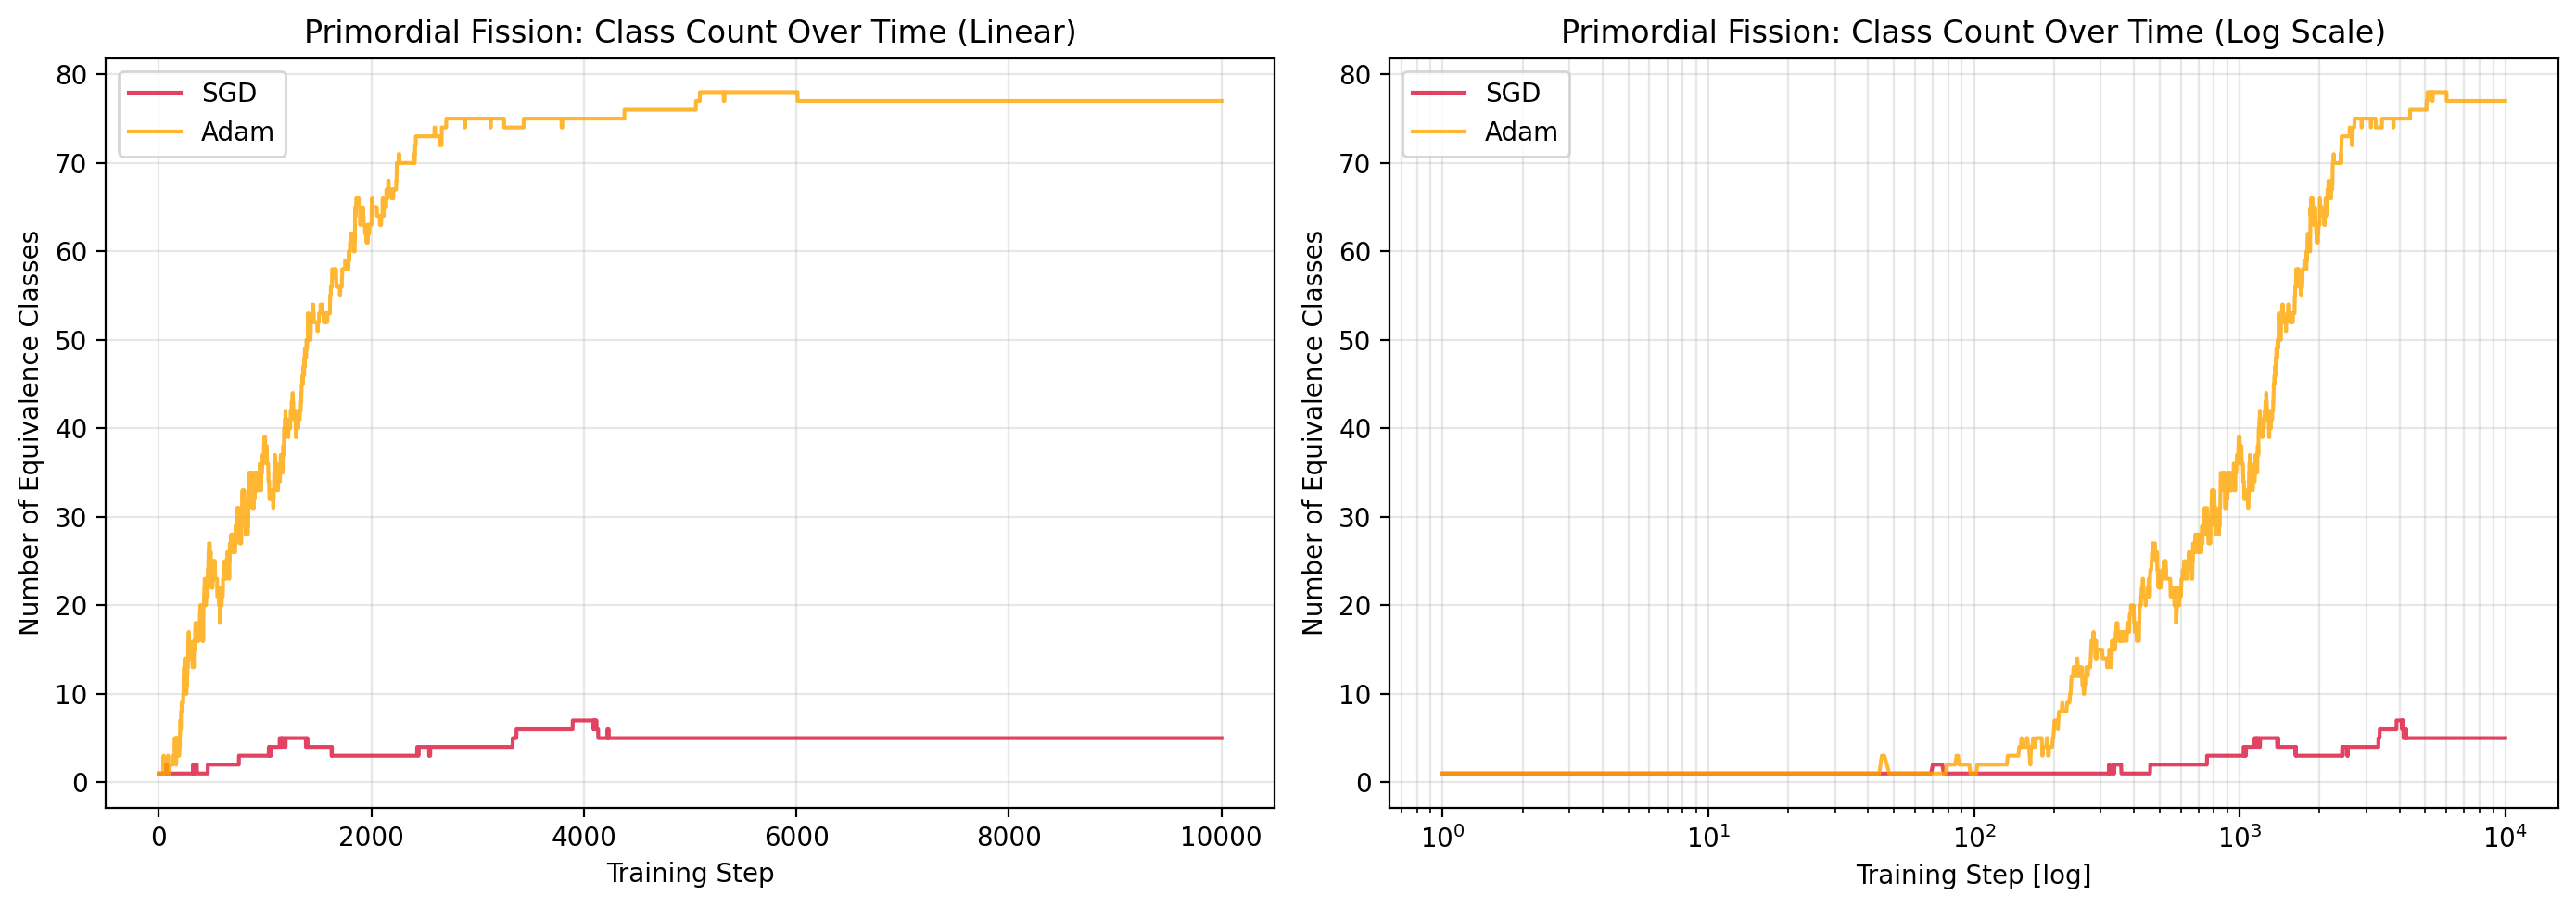

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Extract time series
sgd_n_classes = [s['n_classes'] for s in sgd_evolution]
adam_n_classes = [s['n_classes'] for s in adam_evolution]

# Linear scale
ax1.plot(sgd_steps.numpy(), sgd_n_classes, linewidth=1.5, color='crimson', 
        label='SGD', alpha=0.8)
ax1.plot(adam_steps.numpy(), adam_n_classes, linewidth=1.5, color='orange', 
        label='Adam', alpha=0.8)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Number of Equivalence Classes')
ax1.set_title('Primordial Fission: Class Count Over Time (Linear)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale (x-axis)
ax2.plot(sgd_steps.numpy()[1:], sgd_n_classes[1:], linewidth=1.5, color='crimson', 
        label='SGD', alpha=0.8)
ax2.plot(adam_steps.numpy()[1:], adam_n_classes[1:], linewidth=1.5, color='orange', 
        label='Adam', alpha=0.8)
ax2.set_xlabel('Training Step [log]')
ax2.set_ylabel('Number of Equivalence Classes')
ax2.set_title('Primordial Fission: Class Count Over Time (Log Scale)')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### Main Class Size Over Time

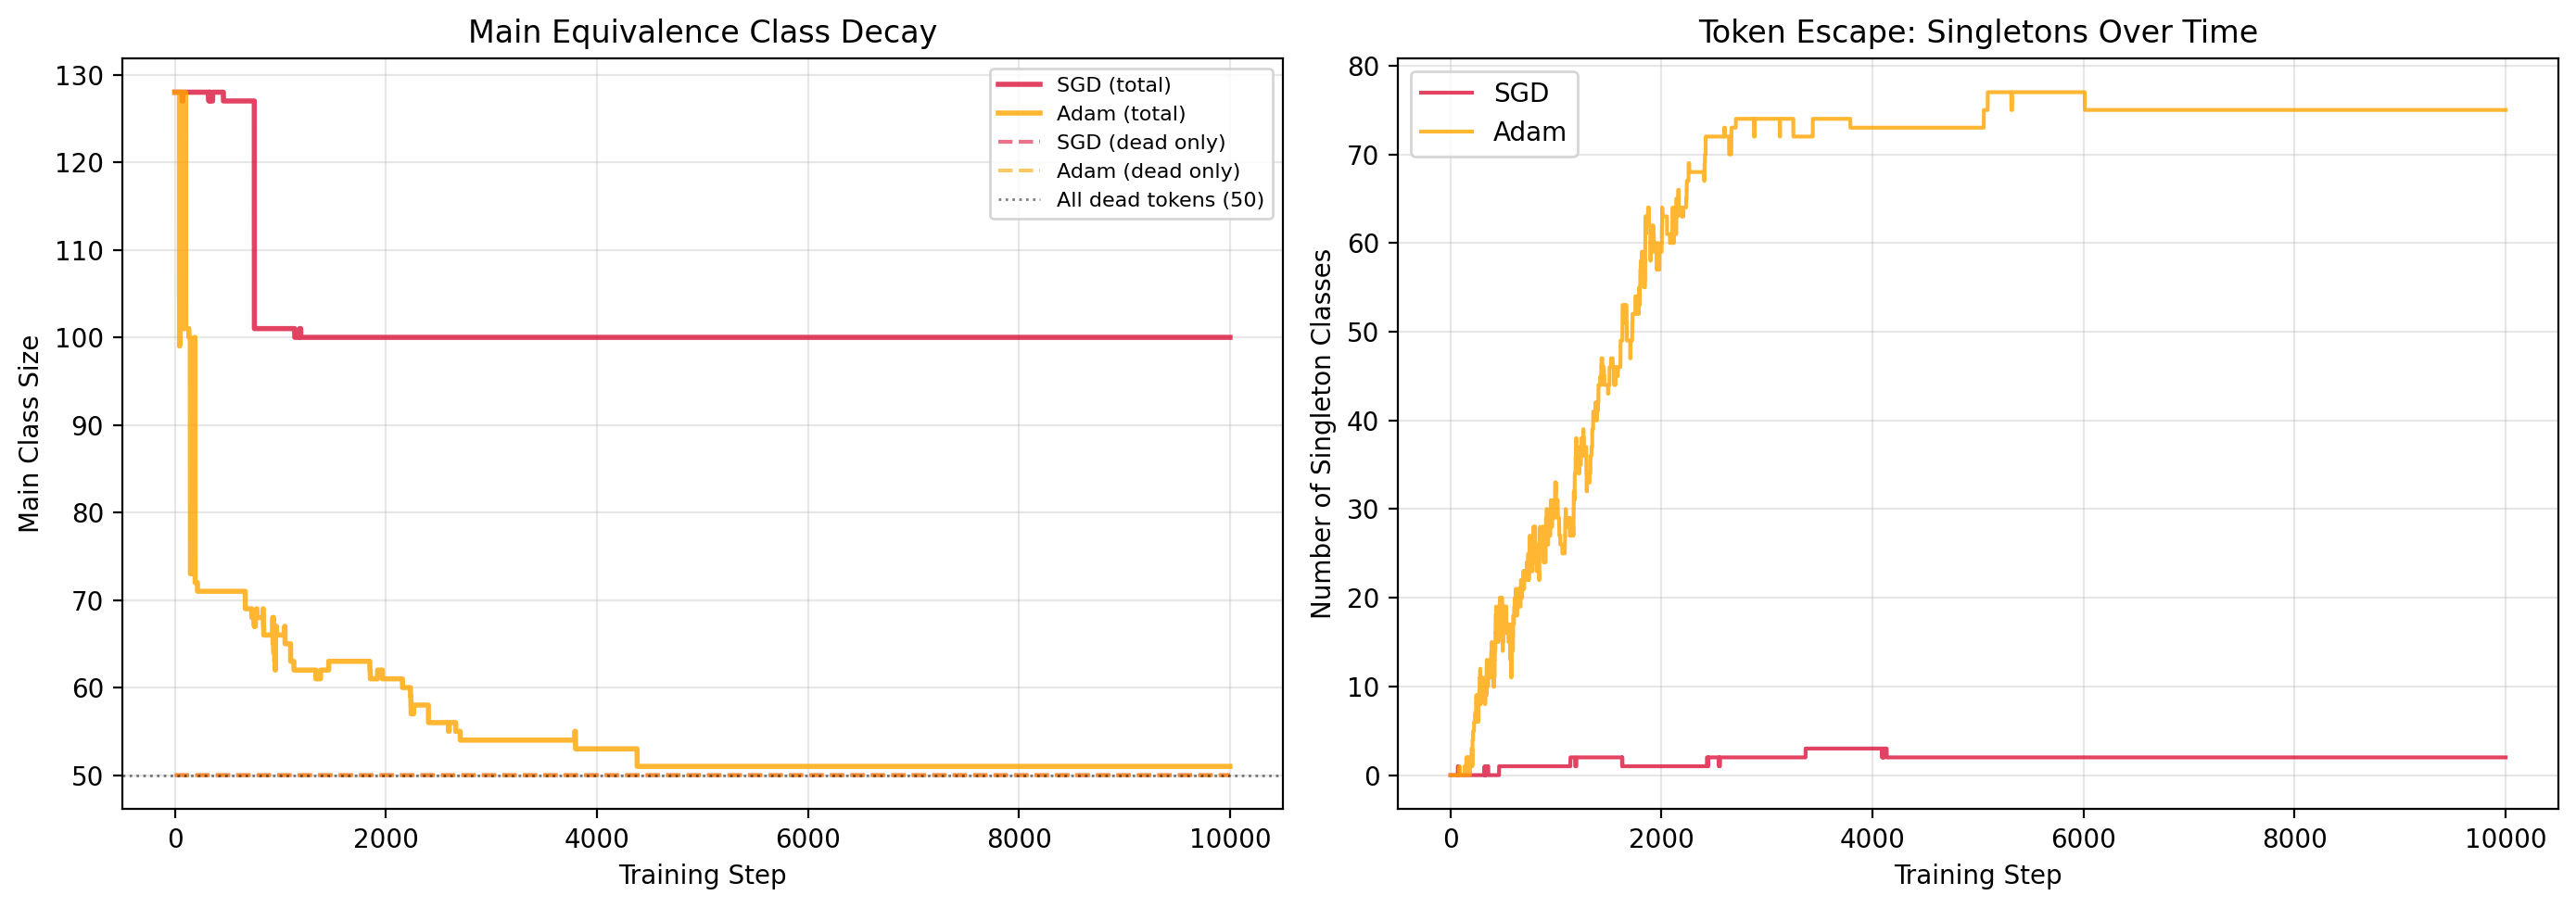

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Extract time series
sgd_main_size = [s['main_size'] for s in sgd_evolution]
adam_main_size = [s['main_size'] for s in adam_evolution]

sgd_main_dead = [s['main_dead'] for s in sgd_evolution]
adam_main_dead = [s['main_dead'] for s in adam_evolution]

# Total main class size
ax1.plot(sgd_steps.numpy(), sgd_main_size, linewidth=2, color='crimson', 
        label='SGD (total)', alpha=0.8)
ax1.plot(adam_steps.numpy(), adam_main_size, linewidth=2, color='orange', 
        label='Adam (total)', alpha=0.8)
ax1.plot(sgd_steps.numpy(), sgd_main_dead, linewidth=1.5, color='crimson', 
        linestyle='--', label='SGD (dead only)', alpha=0.6)
ax1.plot(adam_steps.numpy(), adam_main_dead, linewidth=1.5, color='orange', 
        linestyle='--', label='Adam (dead only)', alpha=0.6)
ax1.axhline(50, color='black', linestyle=':', linewidth=1, alpha=0.5, 
           label='All dead tokens (50)')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Main Class Size')
ax1.set_title('Main Equivalence Class Decay')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Number of singletons (tokens that escaped)
sgd_singletons = [s['n_singletons'] for s in sgd_evolution]
adam_singletons = [s['n_singletons'] for s in adam_evolution]

ax2.plot(sgd_steps.numpy(), sgd_singletons, linewidth=1.5, color='crimson', 
        label='SGD', alpha=0.8)
ax2.plot(adam_steps.numpy(), adam_singletons, linewidth=1.5, color='orange', 
        label='Adam', alpha=0.8)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Number of Singleton Classes')
ax2.set_title('Token Escape: Singletons Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Class Size Distribution at Key Steps

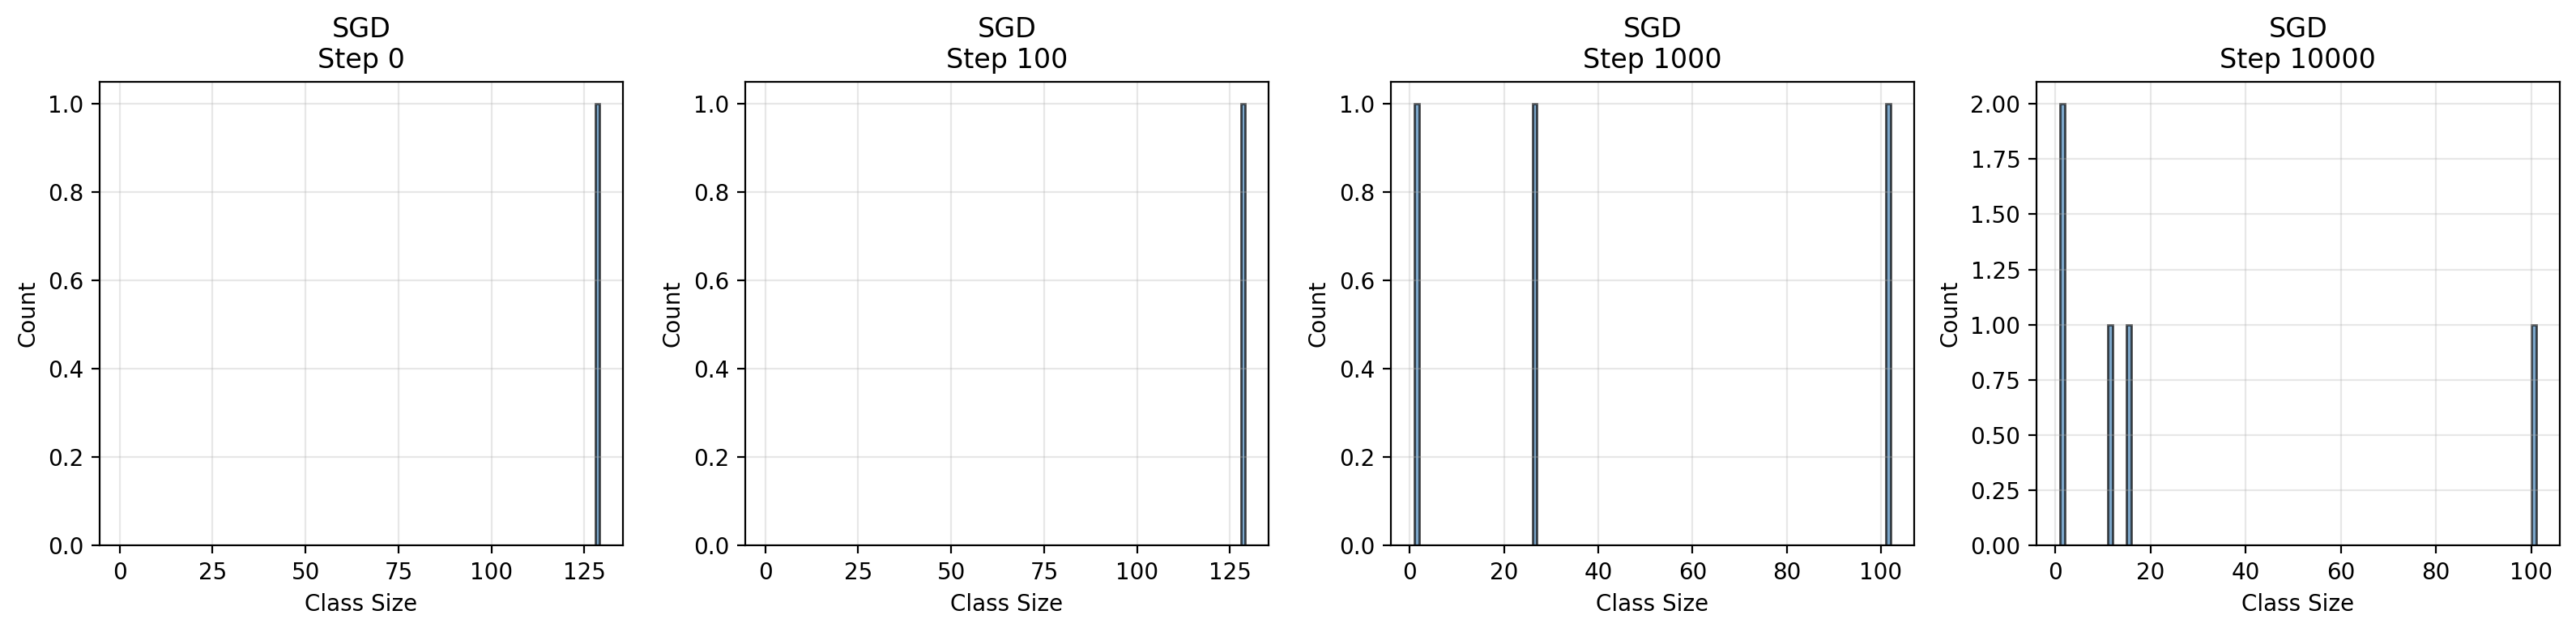

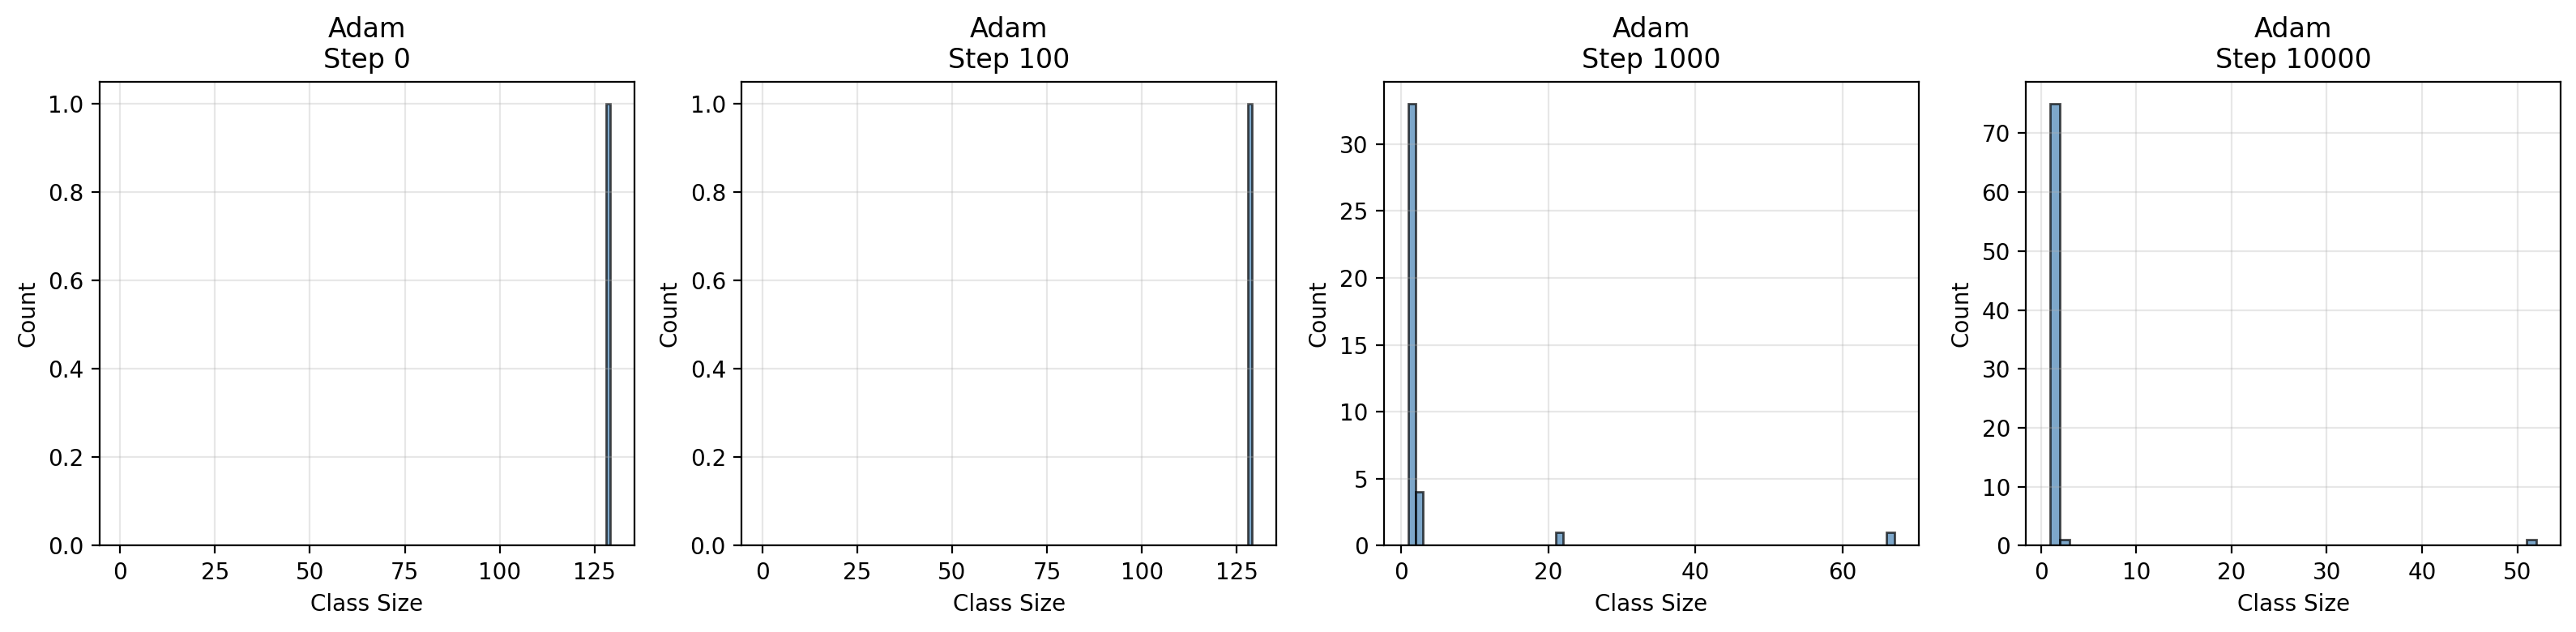

In [11]:
def plot_class_size_distribution(evolution, steps_tensor, target_steps, title):
    """
    Plot histograms of class sizes at specific snapshots.
    """
    n_snapshots = len(target_steps)
    fig, axes = plt.subplots(1, n_snapshots, figsize=(4 * n_snapshots, 4), dpi=DPI)
    
    if n_snapshots == 1:
        axes = [axes]
    
    for i, target_step in enumerate(target_steps):
        # Find closest step
        step_idx = (steps_tensor - target_step).abs().argmin().item()
        actual_step = steps_tensor[step_idx].item()
        
        class_sizes = evolution[step_idx]['class_sizes']
        
        # Histogram
        axes[i].hist(class_sizes, bins=range(1, max(class_sizes) + 2), 
                    color='steelblue', alpha=0.7, edgecolor='black')
        axes[i].set_xlabel('Class Size')
        axes[i].set_ylabel('Count')
        axes[i].set_title(f'{title}\nStep {actual_step}')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# SGD snapshots
plot_class_size_distribution(sgd_evolution, sgd_steps, [0, 100, 1000, 10000], "SGD")

# Adam snapshots
plot_class_size_distribution(adam_evolution, adam_steps, [0, 100, 1000, 10000], "Adam")

## Fission Event Detection

In [15]:
def detect_fission_events(evolution):
    """
    Identify steps where main class size decreases (tokens escape).
    
    Returns:
        fissions: list of (step_idx, old_size, new_size, n_escaped)
    """
    fissions = []
    
    for i in range(1, len(evolution)):
        old_size = evolution[i-1]['main_size']
        new_size = evolution[i]['main_size']
        
        if new_size < old_size:
            n_escaped = old_size - new_size
            fissions.append((i, old_size, new_size, n_escaped))
    
    return fissions

sgd_fissions = detect_fission_events(sgd_evolution)
adam_fissions = detect_fission_events(adam_evolution)

print(f"\nSGD fission events: {len(sgd_fissions)}")
print(f"Adam fission events: {len(adam_fissions)}")

# Show first 10 fissions for each
print("=" * 80)
print("First 10 SGD fissions:")
print("=" * 80)
for step_idx, old_size, new_size, n_escaped in sgd_fissions[:10]:
    actual_step = sgd_steps[step_idx].item()
    print(f"  Step {actual_step}: {old_size} → {new_size} (escaped: {n_escaped})")

print("=" * 80)
print("First 10 Adam fissions:")
print("=" * 80)
for step_idx, old_size, new_size, n_escaped in adam_fissions[:10]:
    actual_step = adam_steps[step_idx].item()
    print(f"  Step {actual_step}: {old_size} → {new_size} (escaped: {n_escaped})")


SGD fission events: 8
Adam fission events: 36
First 10 SGD fissions:
  Step 70: 128 → 127 (escaped: 1)
  Step 323: 128 → 127 (escaped: 1)
  Step 334: 128 → 127 (escaped: 1)
  Step 338: 128 → 127 (escaped: 1)
  Step 461: 128 → 127 (escaped: 1)
  Step 754: 127 → 101 (escaped: 26)
  Step 1137: 101 → 100 (escaped: 1)
  Step 1194: 101 → 100 (escaped: 1)
First 10 Adam fissions:
  Step 45: 128 → 99 (escaped: 29)
  Step 79: 128 → 101 (escaped: 27)
  Step 103: 128 → 101 (escaped: 27)
  Step 134: 101 → 100 (escaped: 1)
  Step 148: 100 → 73 (escaped: 27)
  Step 192: 100 → 72 (escaped: 28)
  Step 215: 72 → 71 (escaped: 1)
  Step 668: 71 → 69 (escaped: 2)
  Step 730: 69 → 68 (escaped: 1)
  Step 753: 68 → 67 (escaped: 1)


### Fission Event Timeline

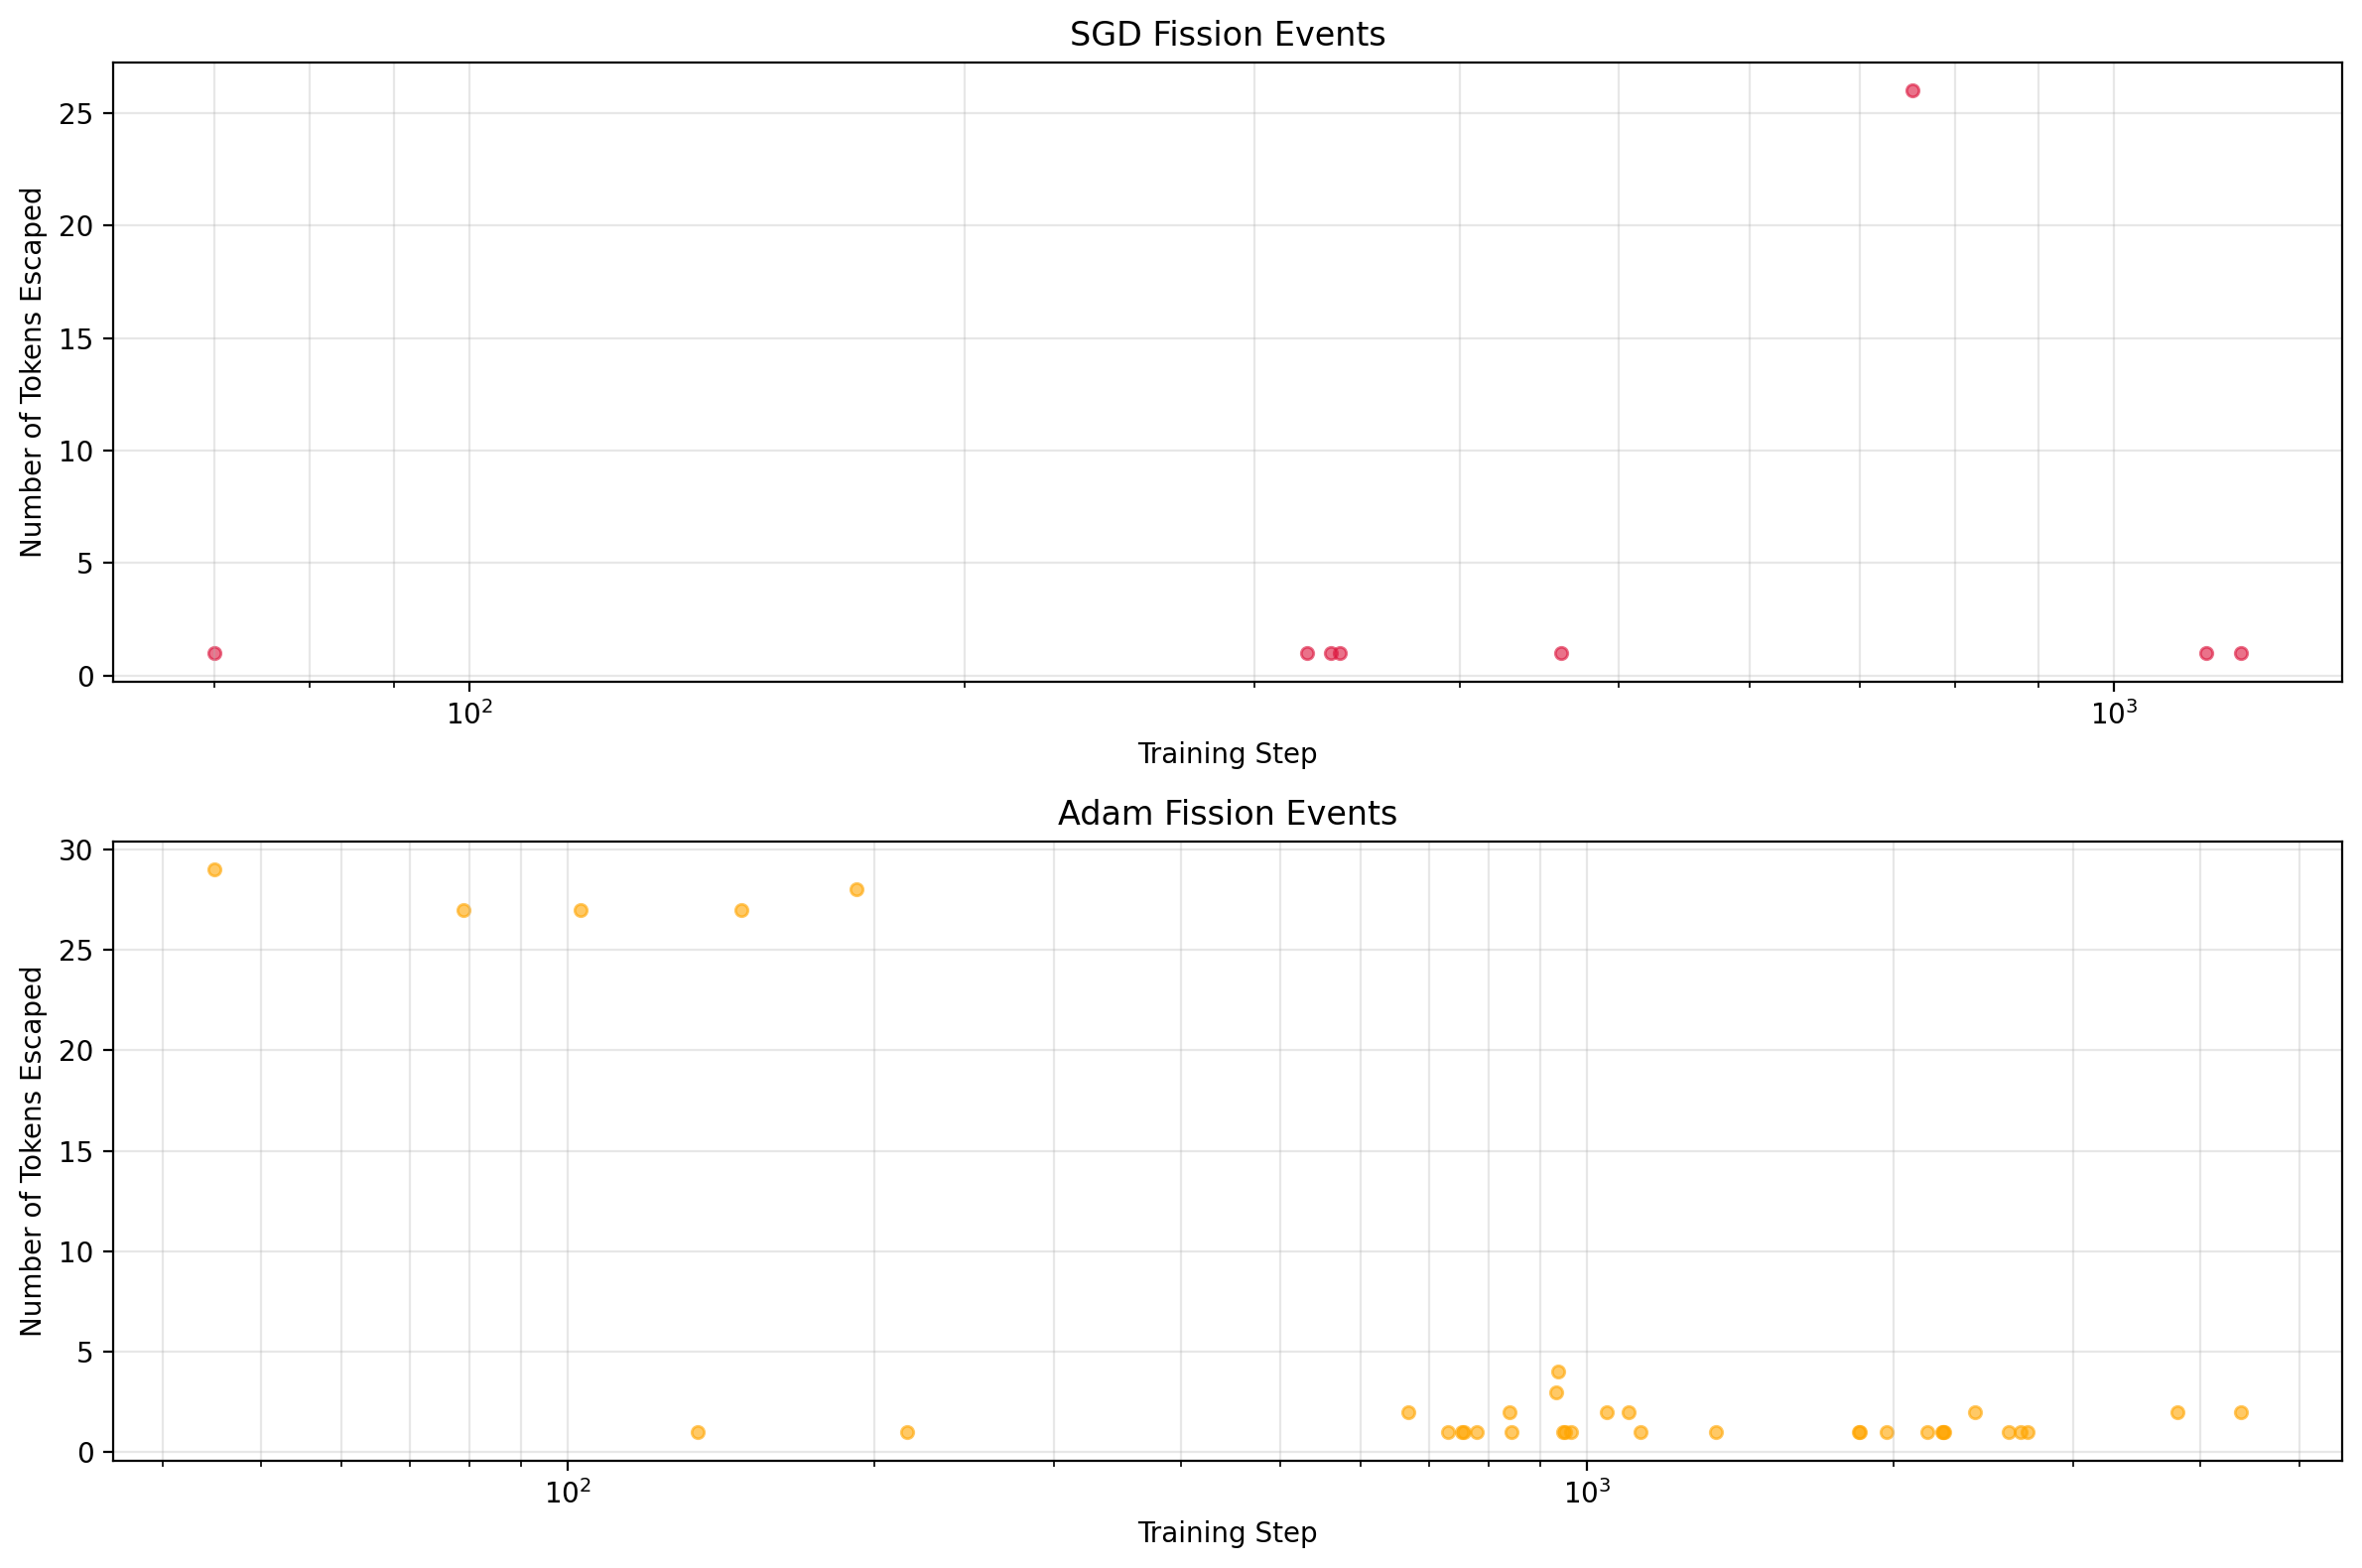

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI)

# SGD fission events
sgd_fission_steps = [sgd_steps[step_idx].item() for step_idx, _, _, _ in sgd_fissions]
sgd_fission_sizes = [n_escaped for _, _, _, n_escaped in sgd_fissions]

ax1.scatter(sgd_fission_steps, sgd_fission_sizes, s=20, color='crimson', alpha=0.6)
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Number of Tokens Escaped')
ax1.set_title('SGD Fission Events')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3, which='both')

# Adam fission events
adam_fission_steps = [adam_steps[step_idx].item() for step_idx, _, _, _ in adam_fissions]
adam_fission_sizes = [n_escaped for _, _, _, n_escaped in adam_fissions]

ax2.scatter(adam_fission_steps, adam_fission_sizes, s=20, color='orange', alpha=0.6)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Number of Tokens Escaped')
ax2.set_title('Adam Fission Events')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Done

In [14]:
print("✓ Pairwise equivalence class analysis complete")

✓ Pairwise equivalence class analysis complete
